In [1]:
# imports
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import re, glob
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [7]:
# useful constants, update once groupthink works
tasks = ["interpolation", "extrapolation"]
models = {"pondernet" : "Pondernet",
          "groupthink" : "Groupthink",
          "pondernet_mnist" : "Pondernet MNIST"}
elems = {"interpolation": 16, "extrapolation": 24}

In [3]:
def get_paths(path):
    """Fetches all relevant paths"""
    files = []
    for f in glob.glob(path):
        files.append(f)
    return files

def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    if not all(
        s in ea.Tags()["scalars"] for s in scalars
    ):
        return None
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), f"some scalars were not found in the event accumulator, {scalars}"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

def get_df(paths, scalars):
    """Gets all dfs of all logs files according to the desired scalars and combines them.
    Only use this if you have single values per scalar per log file, not for time series."""
    df_list = {s:[] for s in scalars}
    for f in paths:
        dict_df = parse_tensorboard(f, scalars)
        if not dict_df:
            # print(f"Not all requested metrics found in {f}")
            continue
        for key, val in dict_df.items():
            val["file"] = f
            val.rename(columns={'value': key}, inplace=True)
            val = val.set_index(val["file"])
            df_list[key].append(val[["step", key]])
    dict_result = {s : pd.concat(df_list[s]) for s in scalars}
    df = pd.concat(list(dict_result.values()), axis = 1)
    df.reset_index(drop=True, inplace=True)
    return df

def get_timeseries_df(paths, scalars):
    """Gets all dfs of all log files and merges them according to similar step."""
    df_list = {s:[] for s in scalars}
    for i, f in enumerate(paths):
        dict_df = parse_tensorboard(f, scalars)
        if not dict_df:
            # print(f"Not all requested metrics found in {f}")
            continue
        for key, val in dict_df.items():
            val.rename(columns={'value': key+f"-v{i}"}, inplace=True)
            val.set_index(val["step"], inplace=True)
            df_list[key].append(val.drop(["wall_time"], axis=1))
    dict_result = {s : (pd.concat(df_list[s], axis=1)).drop(["step"], axis=1) for s in scalars}
    for s in scalars:
        dict_result[s]["Average"] = dict_result[s].mean(axis = 1)
    return dict_result

def get_metrics(phase, scalars, models):
    """Gets metrics"""
    dfs = {}
    for m in models.keys():
        dfs[m] = {}
        for t in tasks:
            if m == "pondernet_mnist":
                num_elems = 28
            else:
                num_elems = elems[t]
            dir_path = f"../models/{m}_{t}_{num_elems}/*/*events*"
            if phase == "test":
                files = get_paths(dir_path)
                df = get_df(files, scalars)
                dfs[m][t] = df.drop(["step"], axis=1)
            elif phase == "val":
                files = get_paths(dir_path)
                dfs[m][t] = get_timeseries_df(files, scalars) 
    if phase == "test":
        to_graph = {t:{s:{m:dfs[m][t][[s]] for m in models} for s in scalars} for t in tasks}
    else:
        to_graph = {t:{s:{m:dfs[m][t][s] for m in models} for s in scalars} for t in tasks}
    return to_graph

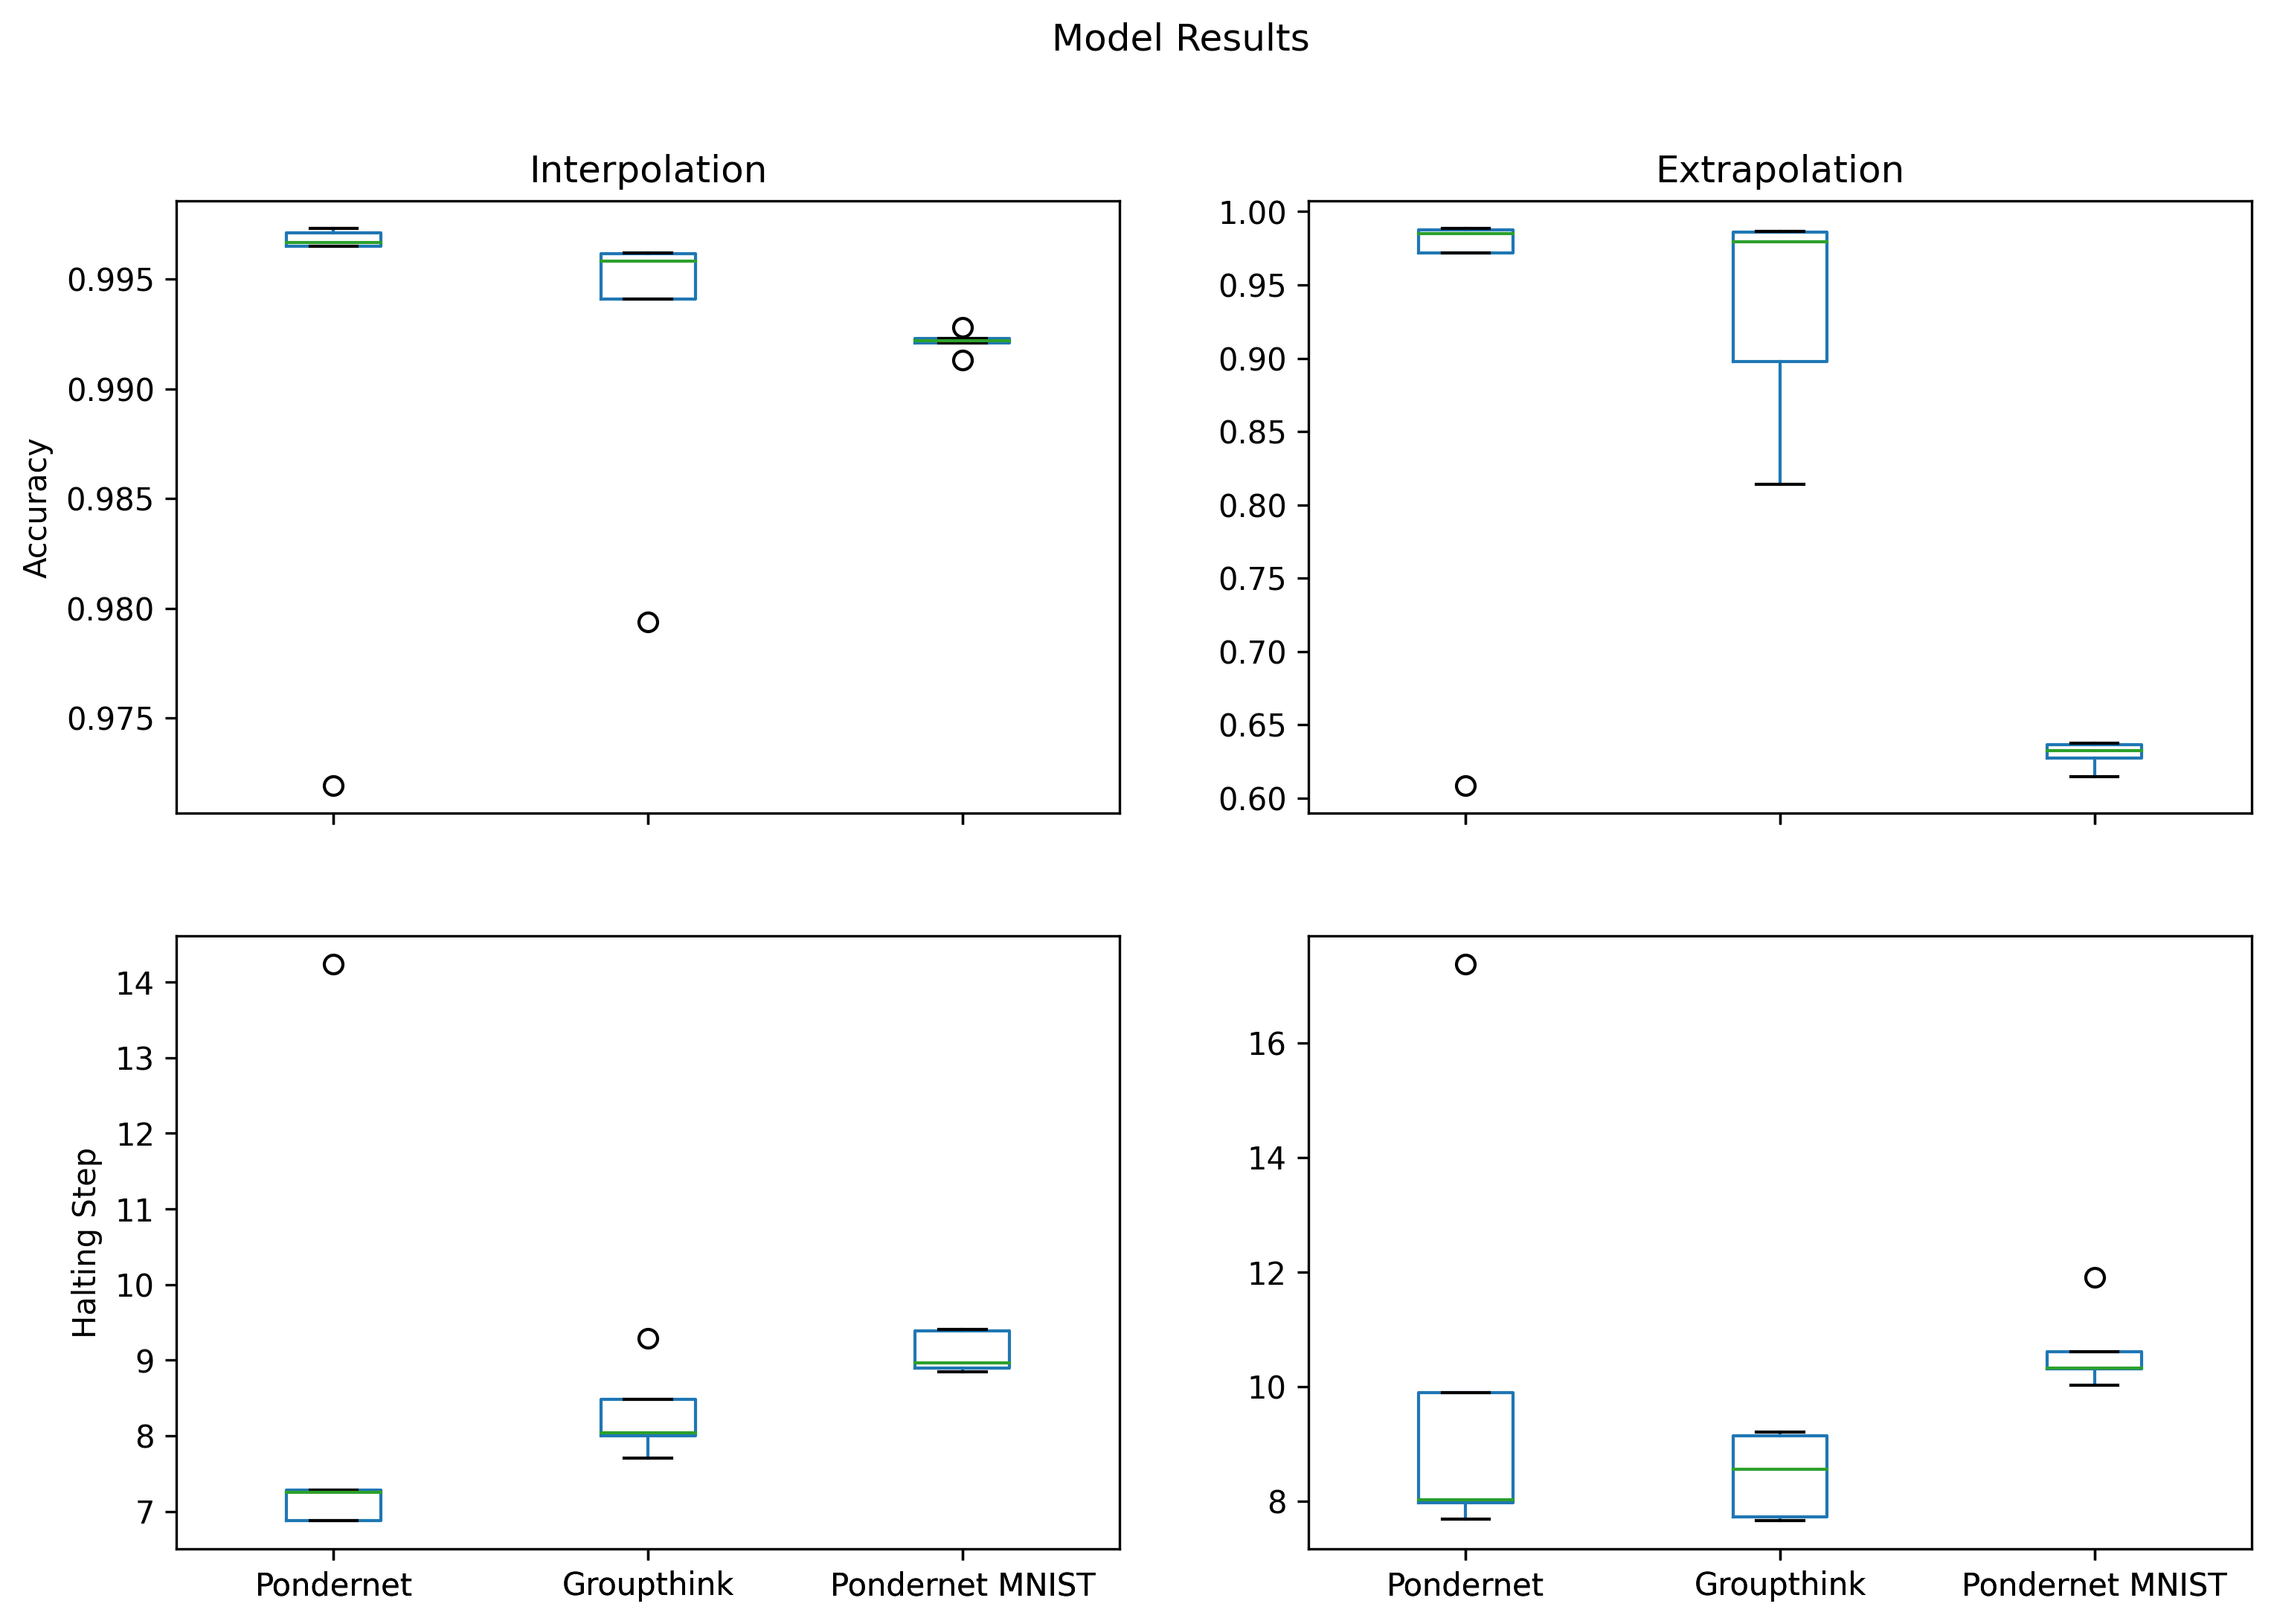

In [8]:
# plotting scalars at test for comparison across models
phase = "test"
scalars = [f'{phase}/accuracy_halted_step', f'{phase}/halting_step']
to_graph = get_metrics(phase, scalars, models)
f, axs = plt.subplots(2, 2, dpi=300, figsize=(12, 8), sharex="col")
for i, t in enumerate(tasks):
    for j, s in enumerate(scalars):
        for m in models.keys():
            to_graph[t][s][m].rename(columns={s: models[m]}, inplace=True)
        boxplt = pd.concat([to_graph[t][s][m] for m in models], axis=1)
        boxplt.boxplot(ax=axs[j,i], grid = False)
        if i % 2 == 0:
            if j % 2 == 0:
                axs[j,i].set_ylabel("Accuracy")
            else:
                axs[j,i].set_ylabel("Halting Step")
    axs[0,i].set_title(t.title())
plt.suptitle('Model Results')
# plt.tight_layout()
plt.show()

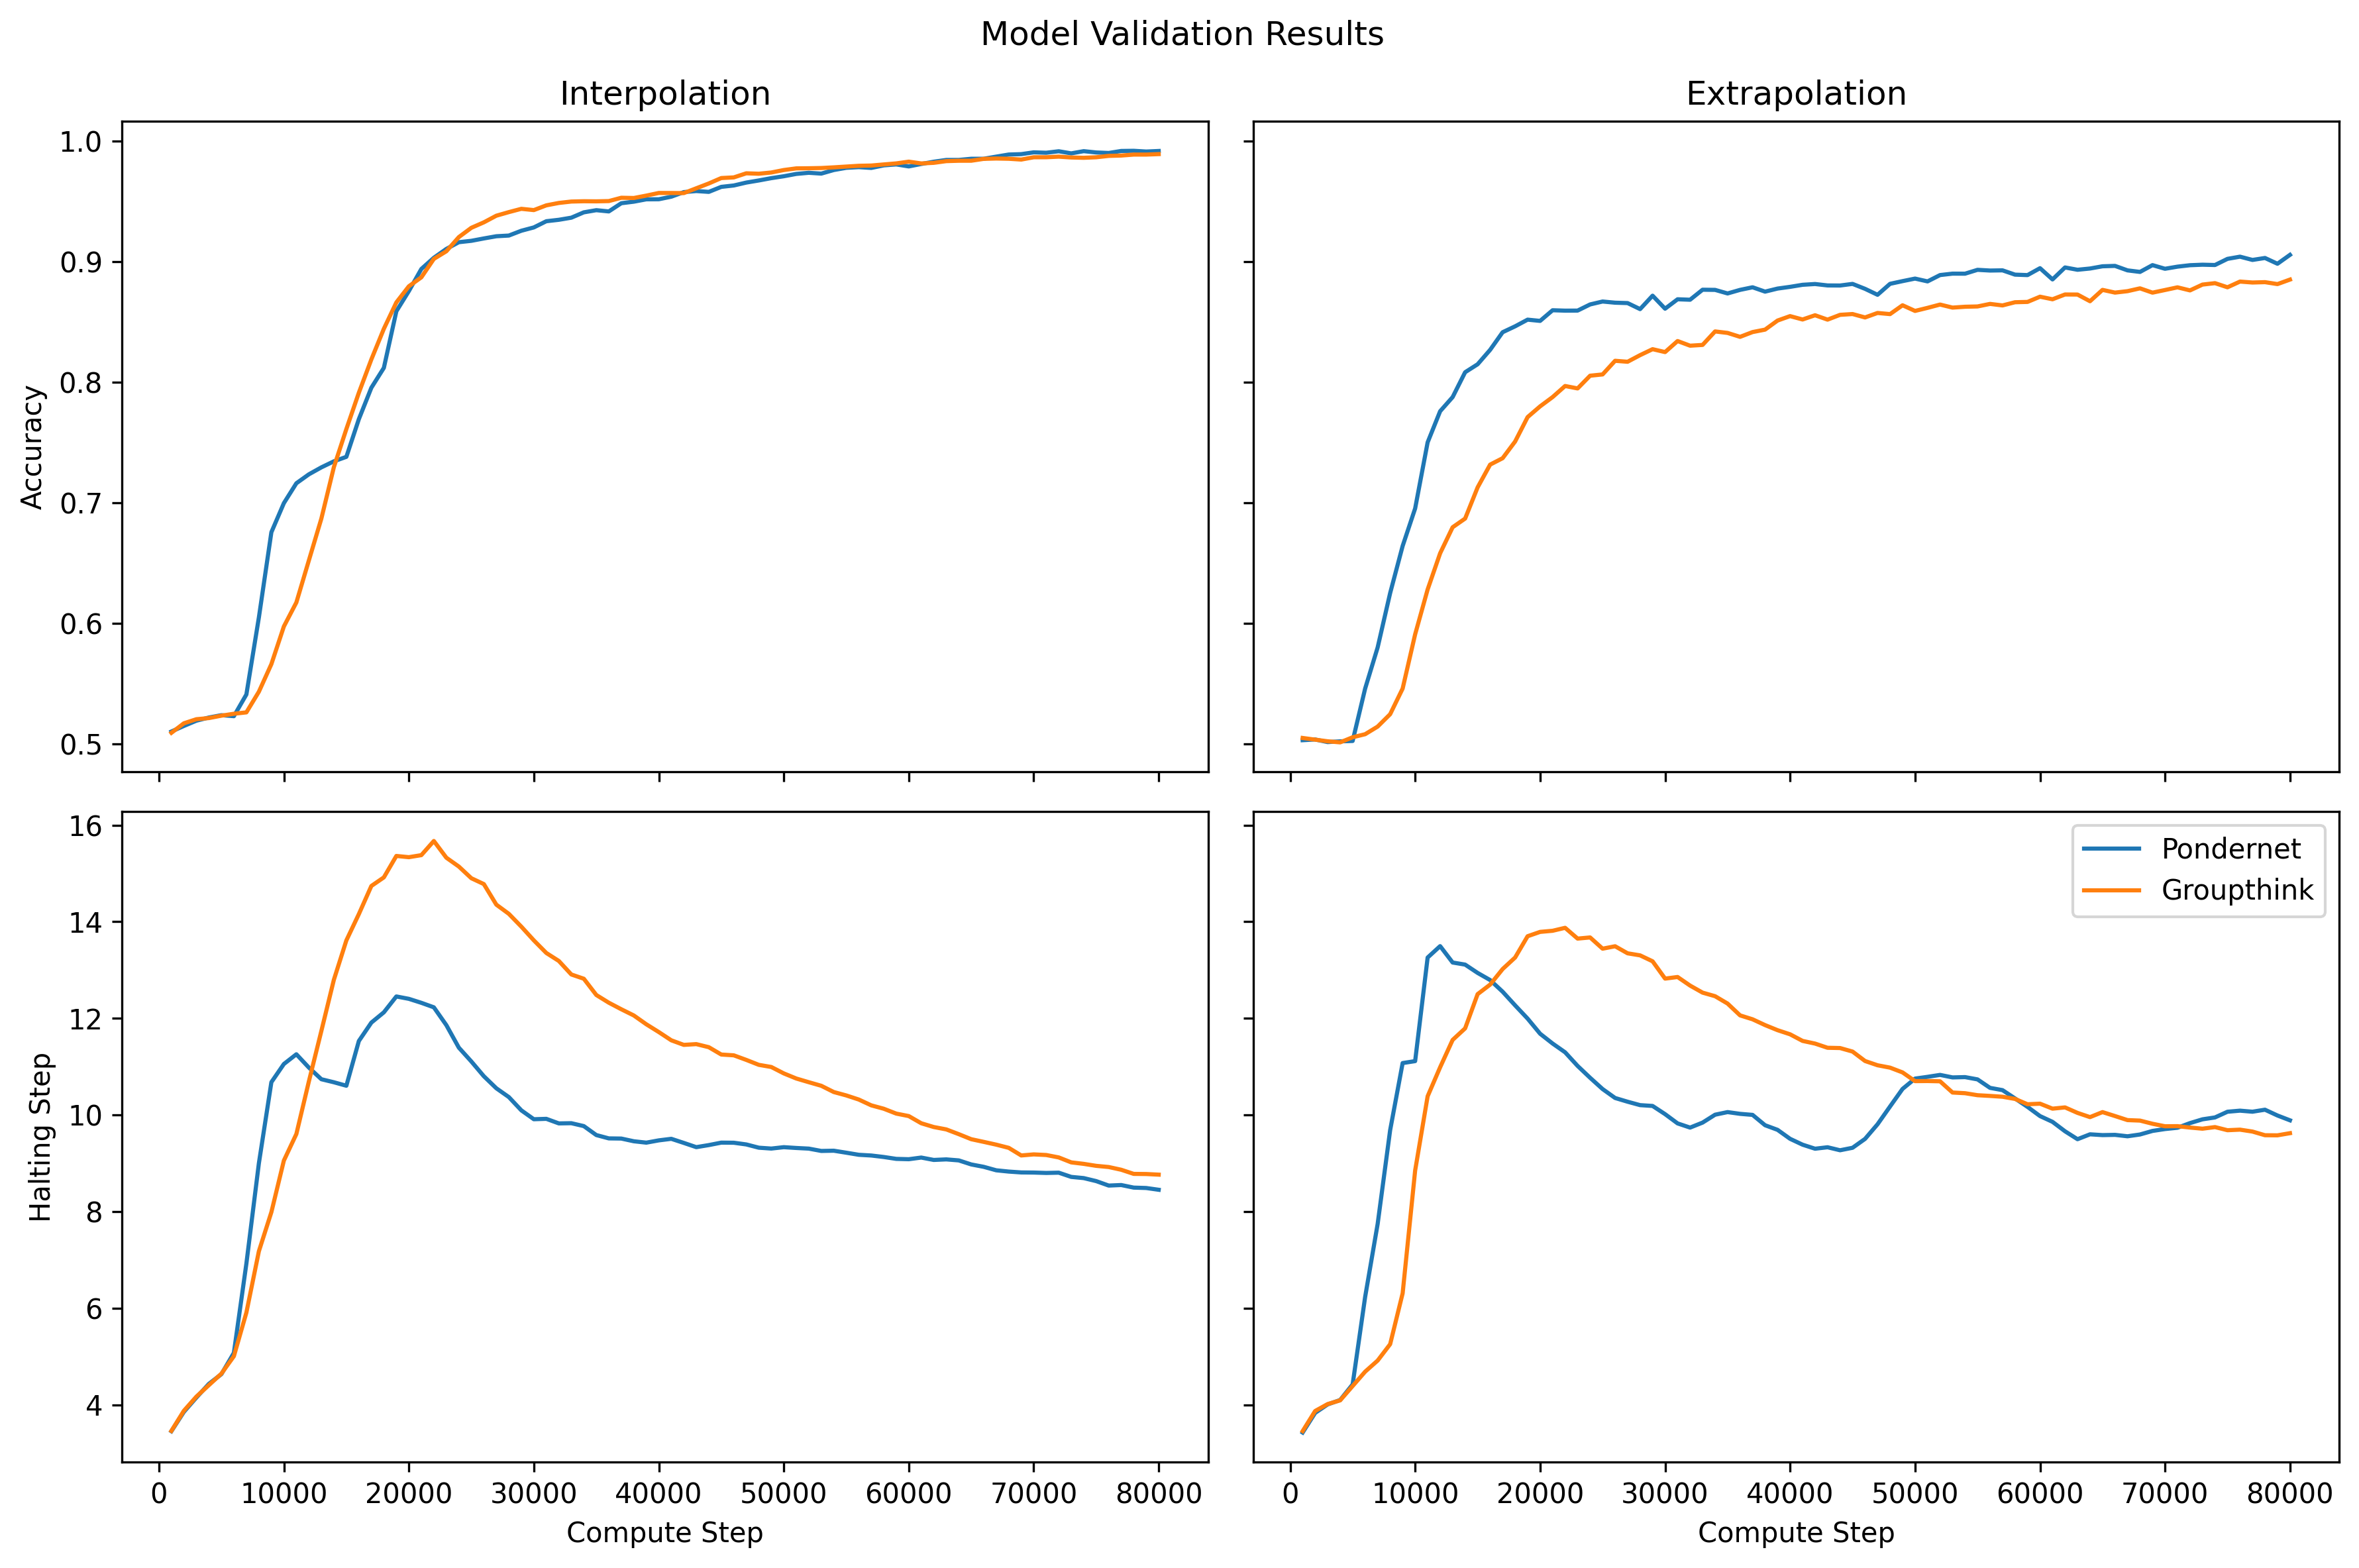

In [14]:
# plotting time series of training for comparison across models
phase = "val"
max_steps = 80_000
scalars = [f'{phase}/accuracy_halted_step', f'{phase}/halting_step']
models = {"pondernet" : "Pondernet",
          "groupthink" : "Groupthink"}
to_graph = get_metrics(phase, scalars, models)
f, axs = plt.subplots(2, 2, dpi=300, figsize=(12, 8), sharey="row", sharex="col")
for i, t in enumerate(tasks):
    for j, s in enumerate(scalars):
        for m in models.keys():
            data = to_graph[t][s][m]
            data.rename(columns={"Average": models[m]}, inplace=True)
            # print(to_graph[t][s][m][models[m]+" Average"][:max_steps])
            data[models[m]][data.index <= max_steps].plot(ax=axs[j,i], grid = False, style=["-"])
            if i % 2 == 0:
                if j % 2 == 0:
                    axs[j,i].set_ylabel("Accuracy")
                else:
                    axs[j,i].set_ylabel("Halting Step")
    axs[0,i].set_title(t.title())
    axs[1,i].set_xlabel("Compute Step")
axs[1,1].legend()
plt.suptitle('Model Validation Results')
plt.tight_layout()
plt.show()